In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


****Import Library necessary****

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set(style = 'white', context = 'notebook', palette = 'deep')

****Data preparation****

In [3]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

(42000,) (42000, 784)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


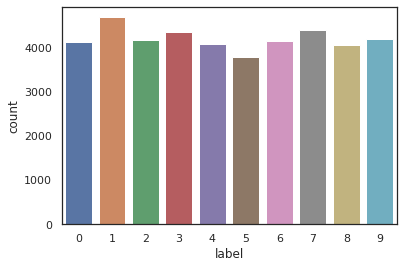

In [4]:
Y_train = train['label']
X_train = train.drop('label', axis = 1)
print(Y_train.shape, X_train.shape)
g = sns.countplot(Y_train)

***Check for null***

In [5]:
X_train.isnull().sum()
test.isnull().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

***Normalize train and test set***

In [6]:
X_train = X_train / 255
test = test / 255

***Reshape train and test set***

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
X_train.shape, test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

***one-hot encoding***

In [8]:
Y_train = to_categorical(Y_train, num_classes = 10)
Y_train.shape

(42000, 10)

**Split training and validation set**

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 2)

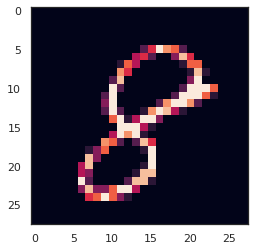

In [10]:
g = plt.imshow(X_train[0])

***Define CNN model***

In [11]:
def conv_model(input_shape: tuple):
    
    input_img = tf.keras.Input(shape = input_shape)
    
    x1 = tfl.Conv2D(32, (5,5), padding = 'same', activation = 'relu')(input_img)
    x1 = tfl.Conv2D(32, (5,5), padding = 'same', activation = 'relu')(x1)
    x1 = tfl.MaxPool2D((2,2), (2,2))(x1)
    x1 = tfl.Dropout(0.25)(x1)
    
    x2 = tfl.Conv2D(64, (3,3), padding = 'same', activation = 'relu')(x1)
    x2 = tfl.Conv2D(64, (3,3), padding = 'same', activation = 'relu')(x2)
    x2 = tfl.MaxPool2D((2,2), (2,2))(x2)
    x2 = tfl.Dropout(0.25)(x2)
    x2 = tfl.Flatten()(x2)
    
    x3 = tfl.Dense(256, activation = 'relu')(x2)
    x3 = tfl.Dropout(0.5)(x3)
    
    output = tfl.Dense(10, activation = 'softmax')(x3)
    
    model = tf.keras.Model(inputs = input_img, outputs = output)
    
    return model

***Make model instance***

In [12]:
model = conv_model(X_train.shape[1:])
print(model.summary)

2022-02-24 11:49:08.906186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 11:49:09.004306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 11:49:09.005401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fa19083c250>>


2022-02-24 11:49:09.007214: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 11:49:09.009810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 11:49:09.010878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 11:49:09.011971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

***Compile model***

In [13]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928 

***Decaying learning rate***

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',
                                           patience = 3,
                                           verbose = 1,
                                           factor = 0.5,
                                           min_lr = 0.00001)

***Set epochs and batch size***

In [15]:
epochs = 30
batch_size = 86

***Data augmentation***

In [16]:
datagen = ImageDataGenerator(rotation_range = 10,
                            zoom_range = 0.1,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1)
datagen.fit(X_train)
datagen

***Fit our model***

In [17]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size = batch_size),
                   epochs = epochs,
                   validation_data = (X_val, Y_val),
                   verbose = 1,
                   steps_per_epoch = X_train.shape[0]//batch_size,
                   callbacks = [learning_rate_reduction])

2022-02-24 11:49:12.111654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-02-24 11:49:13.397817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


439/439 [==============================] - 17s 24ms/step - loss: 0.4176 - accuracy: 0.8633 - val_loss: 0.0800 - val_accuracy: 0.9771
Epoch 2/30
439/439 [==============================] - 10s 23ms/step - loss: 0.1382 - accuracy: 0.9588 - val_loss: 0.0476 - val_accuracy: 0.9857
Epoch 3/30
439/439 [==============================] - 11s 25ms/step - loss: 0.1043 - accuracy: 0.9694 - val_loss: 0.0385 - val_accuracy: 0.9874
Epoch 4/30
439/439 [==============================] - 10s 23ms/step - loss: 0.0845 - accuracy: 0.9758 - val_loss: 0.0441 - val_accuracy: 0.9890
Epoch 5/30
439/439 [==============================] - 11s 25ms/step - loss: 0.0783 - accuracy: 0.9757 - val_loss: 0.0261 - val_accuracy: 0.9910
Epoch 6/30
439/439 [==============================] - 10s 23ms/step - loss: 0.0669 - accuracy: 0.9795 - val_loss: 0.0296 - val_accuracy: 0.9905
Epoch 7/30
439/439 [==============================] - 10s 23ms/step - loss: 0.0614 - accuracy: 0.9821 - val_loss: 0.0212 - val_accuracy: 0.9921
Epo

***Evaluate the model***

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

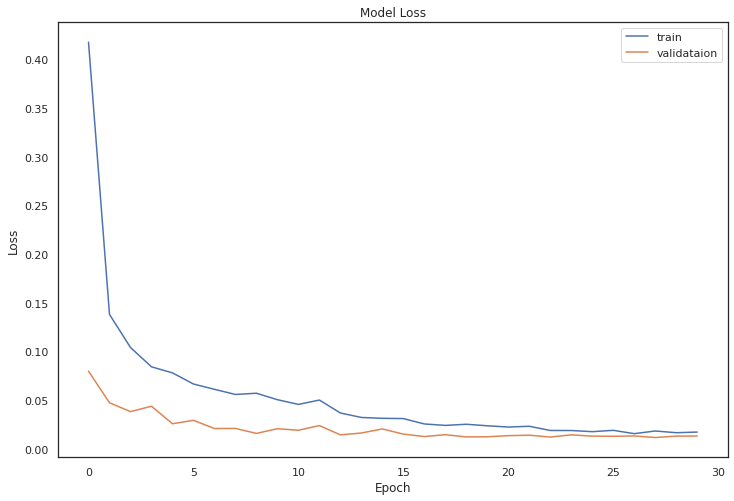

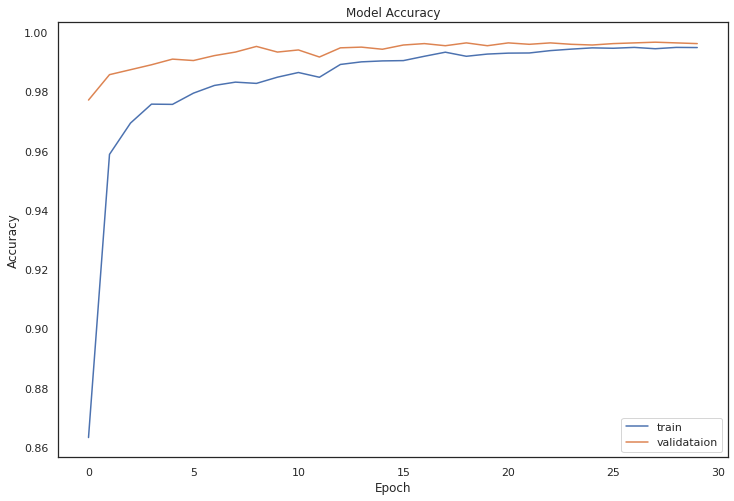

In [18]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[['loss', 'val_loss']]
df_loss.rename(columns = {'loss' : 'train', 'val_loss' : 'validataion'}, inplace = True)

df_acc = df_loss_acc[['accuracy', 'val_accuracy']]
df_acc.rename(columns = {'accuracy' : 'train', 'val_accuracy': 'validataion'}, inplace = True)

df_loss.plot(title = 'Model Loss', figsize = (12, 8)).set(xlabel = 'Epoch', ylabel = 'Loss')
df_acc.plot(title = 'Model Accuracy', figsize = (12, 8)).set(xlabel = 'Epoch', ylabel = 'Accuracy')

***Make Confusion matix***

<AxesSubplot:>

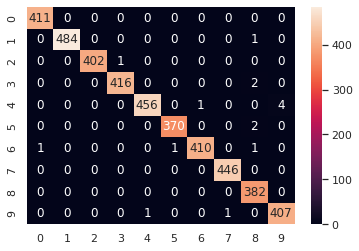

In [19]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
sns.heatmap(confusion_mtx, annot = True, fmt = 'd')

***Predict results and submit***

In [20]:
results = model.predict(test)
results = np.argmax(results, axis = 1)
results = pd.Series(results, name = 'Label')

submission = pd.concat([pd.Series(range(1,28001), name = 'ImageId'), results], axis = 1)
submission.to_csv('../working/submission.csv', index = False)